In [39]:
import tensorflow as tf
from tensorflow import keras

import IPython

print(tf.__version__)

2.8.0


In [40]:
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [41]:
(img_train, label_train), (img_test, label_test) = keras.datasets.fashion_mnist.load_data()

In [42]:
# Normalize pixel values between 0 and 1
img_train = img_train.astype('float32') / 255.0
img_test = img_test.astype('float32') / 255.0

In [43]:
len(img_train), len(img_test)

(60000, 10000)

In [44]:
def model_builder(hp):
  model = keras.Sequential()
  model.add(keras.layers.Flatten(input_shape=(28, 28)))

  # Tune the number of units in the first Dense layer
  # Choose an optimal value between 32-512
  hp_units = hp.Int('units', min_value = 32, max_value = 512, step = 32)
  model.add(keras.layers.Dense(units = hp_units, activation = 'relu'))
  model.add(keras.layers.Dense(10))

  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True), 
                metrics = ['accuracy'])

  return model

In [45]:
tuner = kt.Hyperband(model_builder,
                      objective='val_accuracy',
                      max_epochs= 10,
                      factor=3,
                      directory='my_dir',
                      project_name='theFirstKT')

INFO:tensorflow:Reloading Oracle from existing project my_dir\theFirstKT\oracle.json
INFO:tensorflow:Reloading Tuner from my_dir\theFirstKT\tuner0.json


In [46]:
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)   

In [47]:
tuner.search(img_train, label_train, epochs = 10, validation_data = (img_test, label_test), callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

Trial 30 Complete [00h 00m 56s]
val_accuracy: 0.8547999858856201

Best val_accuracy So Far: 0.8865000009536743
Total elapsed time: 00h 03m 43s
INFO:tensorflow:Oracle triggered exit


In [50]:
best_hps

In [51]:
# Build the model with the optimal hyperparameters and train it on the data
model = tuner.hypermodel.build(best_hps)
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_2 (Dense)             (None, 160)               125600    
                                                                 
 dense_3 (Dense)             (None, 10)                1610      
                                                                 
Total params: 127,210
Trainable params: 127,210
Non-trainable params: 0
_________________________________________________________________


In [52]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(img_train, label_train, epochs = 10, validation_data = (img_test, label_test))

Epoch 1/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.4892 - accuracy: 0.8291 - val_loss: 0.4351 - val_accuracy: 0.8458
Epoch 2/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3719 - accuracy: 0.8651 - val_loss: 0.3934 - val_accuracy: 0.8604
Epoch 3/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3327 - accuracy: 0.8783 - val_loss: 0.3601 - val_accuracy: 0.8672
Epoch 4/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.3108 - accuracy: 0.8865 - val_loss: 0.3527 - val_accuracy: 0.8740
Epoch 5/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2917 - accuracy: 0.8913 - val_loss: 0.3578 - val_accuracy: 0.8700
Epoch 6/10
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2782 - accuracy: 0.8968 - val_loss: 0.3315 - val_accuracy: 0.8834
Epoch 7/10
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2635 - accuracy: 0.9016 - val_loss: 0.3420 - val_accuracy:

In [53]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

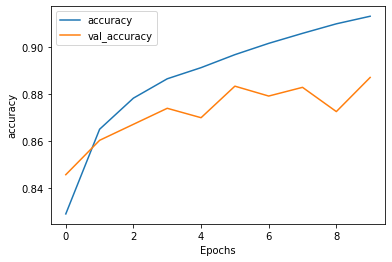

In [54]:
plot_graphs(history, 'accuracy')

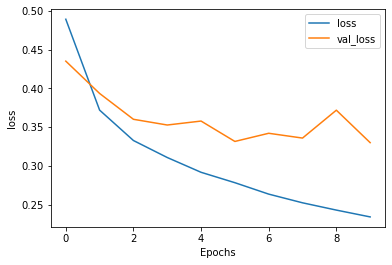

In [55]:
plot_graphs(history, 'loss')

In [81]:
prediction = model.predict(img_test)
#prediction = model.predict(img_train)

In [82]:
digit = 3
selected_digit = digit - 1

result = prediction[selected_digit]
result_number = np.argmax(result)
print(result)
print('Number is %2d' % result_number)
print(label_test[selected_digit])
#print(label_train[selected_digit])

[ -3.1710627  21.69598   -16.142382   -3.2293189  -6.7152405 -24.926825
  -8.815132  -27.957638  -17.207802  -20.555525 ]
Number is  1
1
